## This is the code kindly shared by J. Self, first author of the paper:
#### Self, J.; Bergstrom, H. K. Hypoeutectic Liquid-Solid Phase Diagrams for Ternary Lithium-Ion Battery Electrolytes. Journal of Physical Chemistry Letters 2024, 15 (2), 416-421, Article. DOI: 10.1021/acs.jpclett.3c03169.


In [1]:
# Simplified code for JPCL paper (draft) for Ruihe Li - JS 2024-02-13
import numpy as np, matplotlib.pyplot as plt, pandas as pd, scipy
from scipy import stats,integrate
import sympy as sy;from sympy import symbols,diff
plt.rc('font', size=12)

In [2]:
###### 1) global variables ######
m_bar_EC,m_bar_EMC=0.088,0.104

######numerical variables####
nopoints=200000
###### functions #########
def diff_central(a, b):   # self defined function to do differential
    xdc0,xdc1,xdc2 = a[:-2],a[1:-1],a[2:]
    ydc0,ydc1,ydc2 = b[:-2],b[1:-1],b[2:]
    fdc = (xdc2 - xdc1)/(xdc2 - xdc0)
    return (1-fdc)*(ydc2 - ydc1)/(xdc2 - xdc1) + fdc*(ydc1 - ydc0)/(xdc1 - xdc0)
#############

In [3]:
# 2) Activities of EC and EMC in binary system #######
def Fun_a_EC_EMC_eq2(xx_exp,m_e, para_i_salt ): # Eq. (2) for EC - LiPF6
    [c_i_salt,d_i_salt,e_i_salt,f_i_salt] = para_i_salt
    temp=(
        (1-(2*m_e)/(2*m_e+1/m_bar_EC)) * 
        xx_exp(
            c_i_salt*m_e**1.5 + 
            d_i_salt*m_e**2  + 
            e_i_salt*m_e**2.5 + 
            f_i_salt*m_e**3))
    return(temp)

def Fun_a_EC_EMC_eq3(xx_exp,X_EMC_apo,para_i_j): # i=EC, j=EMC     Eq. (3) for  EC - EMC 
    [c_i_j,d_i_j,e_i_j] = para_i_j
    temp=(
        (1-X_EMC_apo) *    # Mark: equation said X_EMC but script said X_EMC_apo
        xx_exp(
            c_i_j*X_EMC_apo**2 + 
            d_i_j*X_EMC_apo**3 + 
            e_i_j*X_EMC_apo**4))
    return(temp)

def Fun_a_EMC_EC_eq2(xx_exp,m_e,para_i_salt): # Eq. (2) for EMC - LiPF6
    [c_i_salt,d_i_salt,e_i_salt,f_i_salt] = para_i_salt
    temp=(
        (1-(2*m_e)/(2*m_e+1/m_bar_EMC)) *
        xx_exp(
            c_i_salt*m_e**1.5 + 
            d_i_salt*m_e**2  + 
            e_i_salt*m_e**2.5 + 
            f_i_salt*m_e**3))
    return(temp)
################################## parametrized #####
def Fun_a_EMC_EC_eq3(xx_exp,X_EC_apo,para_i_j): # i=EMC j=EC     Eq. (3) for  EMC-EC 
    [c_i_j,d_i_j,e_i_j] = para_i_j
    temp=(1-X_EC_apo)*xx_exp(
        c_i_j*X_EC_apo**2  +  
        d_i_j*X_EC_apo**3  + 
        e_i_j*X_EC_apo**4   ) #three suffix Margules
    return(temp)

In [4]:
################################################################
########### 4) Establishing mixing rules #######################
################################################################
########### binary global parameters ###########################
para_EC_salt = [0.042895, -0.38832, 0.0663, -0.017291]
para_EC_EMC  = [-0.66992, 4.2840,   -2.5671,   ]
para_EC_EMC_salt = [2.7936, -7.8747, 1.7636] 

para_EMC_salt = [0.82629, -1.7913, 1.7011, -0.63441]
para_EMC_EC  = [0.62190, 2.5617,   -2.5672,    ]

###############   Eq. (7)  #############################
def Fun_a_EC_simplified(xx_exp,m_e,X_EMC,para_i_j_salt,alpha): # aEC  i=EC
    [c_i_j_salt,d_i_j_salt,e_i_j_salt] = para_i_j_salt
    X_EMC_apo=X_EMC/(X_EMC+X_EMC*alpha)
    X_EC_apo =X_EMC_apo*alpha
    first_term  =X_EMC*alpha
    second_term =Fun_a_EC_EMC_eq3(xx_exp,
        X_EMC_apo,para_EC_EMC) / (1-X_EMC_apo)
    third_term  =Fun_a_EC_EMC_eq2(xx_exp,
        m_e,para_EC_salt)/   (1-(2*m_e)/(2*m_e+1/m_bar_EC))
    fourth_term =xx_exp(
        c_i_j_salt*m_e**1.5*X_EMC_apo**2 + 
        d_i_j_salt*m_e**1.5*X_EMC_apo**3 + 
        e_i_j_salt*m_e**2*X_EMC_apo**2  )
    ai_tern = first_term*second_term*third_term*fourth_term
    return(ai_tern)#
def Fun_a_EMC_simplified(xx_exp,m_e,X_EC,alpha): # aEMC 
    X_EC_apo=X_EC/(X_EC*alpha+X_EC)  
    X_EMC =X_EC/(alpha+1E-16)
    first_term=X_EMC
    second_term = Fun_a_EMC_EC_eq3(xx_exp,X_EC_apo,para_EMC_EC)/(1-X_EC_apo) 
    third_term  = Fun_a_EMC_EC_eq2(xx_exp,m_e,para_EMC_salt) / (
        1-  (2*m_e)/(2*m_e+1/m_bar_EMC))
    ai_tern = first_term*second_term*third_term
    return(ai_tern)

In [5]:
# alpha is the mole ratio between EC:EMC  -> m_EC/m_EMC = alpha

In [6]:
####  TD Factor function (eq 10) ####
def calculatedTDfactor(xx_log, xx_exp, alpha=1):
    nopoints=40
    xLiTest=np.linspace(0,0.1,nopoints)
    mEC=1/(m_bar_EC+m_bar_EMC/alpha)
    mEMC=mEC/alpha
    mLiTest=(mEC+mEMC)*xLiTest/(1-2*xLiTest) # mEC+mEMC
    X_EMC =  mEMC / (mEMC+mEC+2*mLiTest)
    X_EC  =  mEC  / (mEC+mEMC+2*mLiTest)
    aEC=Fun_a_EC_simplified(xx_log,mLiTest,X_EMC,para_EC_EMC_salt,alpha=alpha)
    aEMC=Fun_a_EMC_simplified(xx_log,mLiTest,X_EC,alpha=alpha)
    tempGD = (
        - 0.5* mEMC * xx_exp(aEMC[:] / aEMC[0]) 
        - 0.5* mEC  * xx_exp(aEC[:]  / aEC[0] ) 
        )
    calculatedTDfactorRETURN=diff_central(mLiTest[4:],tempGD[:-4])
    return(mLiTest[2+4:],calculatedTDfactorRETURN,aEMC,aEC,tempGD)

x11,yTDF11,aEMC11,aEC11,tempGD11=calculatedTDfactor(np.log,np.exp,alpha=1.18) # "EC:EMC 6:5"
#x10,yTDF10,aEMC10,aEC10=calculatedTDfactor(alpha=1e4)  # "neat EC"
# x01,yTDF01,aEMC01,aEC01=calculatedTDfactor(alpha=1e-4) # "neat EMC"

/tmp/ipykernel_13966/2790069097.py:6: RuntimeWarning: divide by zero encountered in log
  xx_exp(
/tmp/ipykernel_13966/2790069097.py:6: RuntimeWarning: invalid value encountered in log
  xx_exp(
/tmp/ipykernel_13966/3416714237.py:22: RuntimeWarning: divide by zero encountered in log
  fourth_term =xx_exp(
/tmp/ipykernel_13966/3416714237.py:22: RuntimeWarning: invalid value encountered in log
  fourth_term =xx_exp(
/tmp/ipykernel_13966/2790069097.py:27: RuntimeWarning: divide by zero encountered in log
  xx_exp(
/tmp/ipykernel_13966/3659709625.py:13: RuntimeWarning: invalid value encountered in divide
  - 0.5* mEMC * xx_exp(aEMC[:] / aEMC[0])
/tmp/ipykernel_13966/3659709625.py:14: RuntimeWarning: invalid value encountered in divide
  - 0.5* mEC  * xx_exp(aEC[:]  / aEC[0] )


def fun_synp(log_function, alpha=1):
    return log_function(alpha)
import numpy as np
import sympy as sy

# Using NumPy's log function
result_np = fun_synp(np.log, 10)

# Using SymPy's log function
alpha_sy = sy.symbols('alpha')  # Assuming you're working with symbols in SymPy
result_sy = fun_synp(xx_log, alpha_sy)

print("Result with NumPy:", result_np)
print("Result with SymPy:", result_sy)


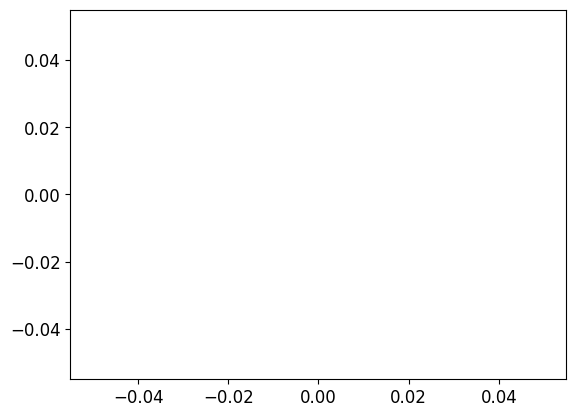

In [7]:
plt.plot(x11,tempGD11[6:],'b',label="EC:EMC 6:5")

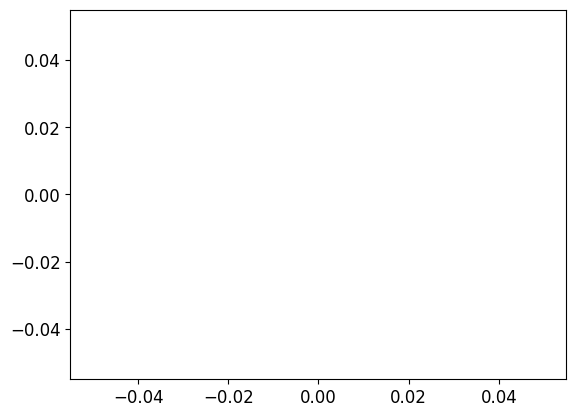

In [8]:
plt.plot(x11,np.diff(tempGD11[5:]),'b',label="EC:EMC 6:5")

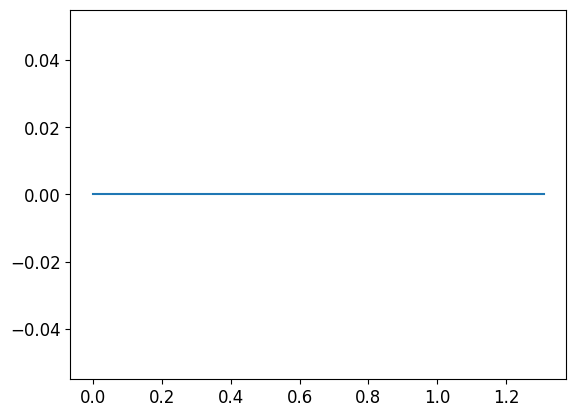

In [9]:
def Fun_tem_R(xx_log,m_e,alpha=1):
    m_bar_EC = 88.062*1e-3 #   kg/mol
    m_bar_0  = 104.105*1e-3 #   kg/mol
    m_bar_EMC= 104.105*1e-3 #   kg/mol
    m_bar_e  = 151.905*1e-3 #   kg/mol
    # assume 1 kg EC and EMC, 
    n_EC  = 0.5 / m_bar_EC   # unit: mol
    n_EMC = 0.5 / m_bar_0    # unit: mol
    mEC  = n_EC/ 1          # unit: mol/kg
    mEMC = n_EMC/ 1         # unit: mol/kg
    nopoints=100000
    #xLiTest=np.linspace(0,0.1,nopoints)

    mLiTest= m_e
    X_EMC =  mEMC / (mEMC+mEC+2*mLiTest)
    X_EC  =  mEC  / (mEC+mEMC+2*mLiTest)
    aEC   = Fun_a_EC_simplified(xx_log,mLiTest,X_EMC,para_EC_EMC_salt,alpha=alpha)
    aEC_0 = Fun_a_EC_simplified(xx_log,0,X_EMC,para_EC_EMC_salt,alpha=alpha)
    aEMC=Fun_a_EMC_simplified(xx_log,mLiTest,X_EC,alpha=alpha)
    aEMC_0=Fun_a_EMC_simplified(xx_log,0,X_EC,alpha=alpha)
    first_term = mEMC * xx_log(aEMC / aEMC_0)
    second_term = mEC * xx_log(aEC / aEC_0)
    
    return first_term + second_term

x=symbols("x",real=True)
TDF_Salt = -0.5* diff(Fun_tem_R(sy.log,x,alpha=1.1822),x)
m_e_List =  np.linspace(0.0,1.31,100).tolist()
TDF_Salt_List = []
for m_e in m_e_List:
    TDF_Salt_List.append(TDF_Salt.subs({x:m_e}))
plt.plot(m_e_List,TDF_Salt_List)

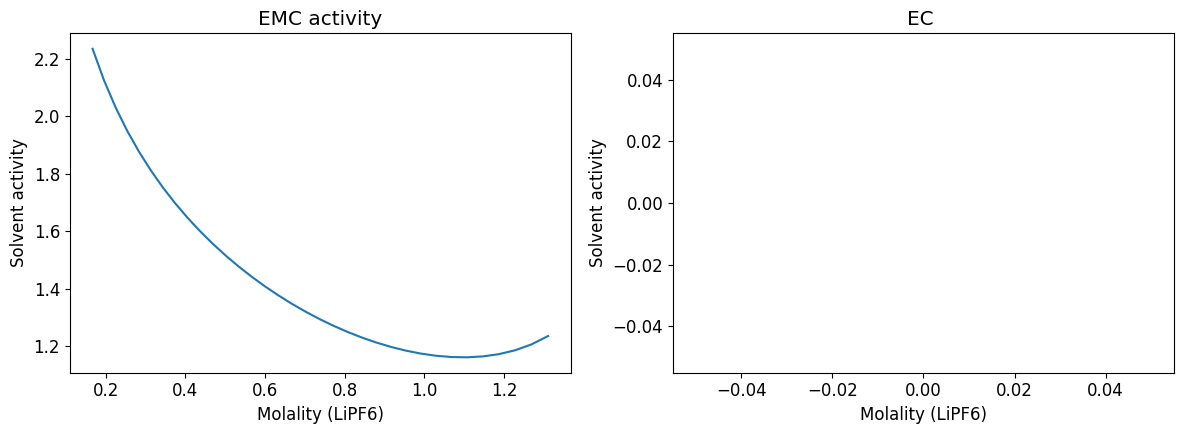

In [10]:
# plot activity
# Plot:
fig, axs = plt.subplots(1,2, figsize=(12,4.5),tight_layout=True)
axs[0].plot(x11,aEMC11[6:])
axs[1].plot(x11,aEC11[6:])
axs[0].set_title("EMC activity")
axs[1].set_title("EC ")
for i in range(2):
    axs[i].set_ylabel("Solvent activity")
    axs[i].set_xlabel("Molality (LiPF6)")

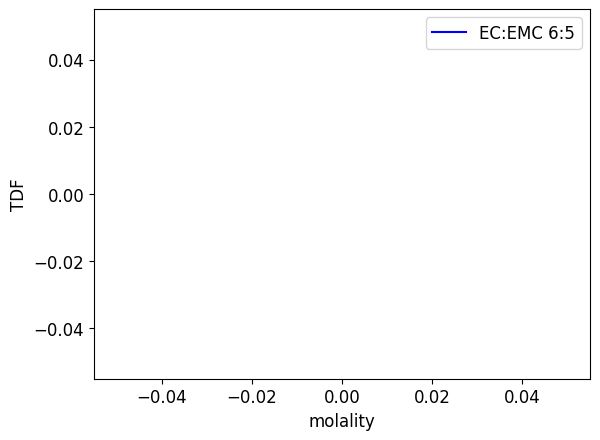

In [11]:
#plt.plot(np.sqrt(x10),yTDF10,label="neat EC")
#plt.plot(np.sqrt(x10),yTDF01,label="neat EMC")
plt.plot(x11,yTDF11,'b',label="EC:EMC 6:5")
plt.xlabel("molality")
plt.ylabel("TDF")
plt.legend()
#plt.xlim(-1e-2,1e-2)
#plt.ylim(1-1e-2,1+1e-2)